## 0. Data download

## 1. Folder init ()

In [1]:
import re
import csv
import os
import pandas as pd

nn = 40000 # for synthetic data size
batch_size = [20, 40, 80, 100, 200, 250, 400, 500]
batch_count = [int(nn/bs) for bs in batch_size]
exa_path = './synthetic_ds'

folder_names = [exa_path]
for bs in batch_size:
    folder_names.append("./batchsize_" + str(bs))

for folder_name in folder_names:
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
        print(f"Folder '{folder_name}' created successfully.")
    else:
        print(f"Folder '{folder_name}' already exists.")

folder_name_sum = './outputs_sum'
if not os.path.exists(folder_name_sum):
    os.makedirs(folder_name_sum)
    print(f"Folder '{folder_name_sum}' created successfully.")
else:
    print(f"Folder '{folder_name_sum}' already exists.")

Folder './synthetic_ds' already exists.
Folder './batchsize_20' already exists.
Folder './batchsize_40' already exists.
Folder './batchsize_80' already exists.
Folder './batchsize_100' already exists.
Folder './batchsize_200' already exists.
Folder './batchsize_250' already exists.
Folder './batchsize_400' already exists.
Folder './batchsize_500' already exists.
Folder './outputs_sum' already exists.


## 2. log data preprocessing (ExaGeostat)

In [2]:
n_zvecs = 100  # total number of zvecs

### 2.2 log file summary

In [3]:
exa_files = [os.path.join(exa_path, 'log_40000_univariate_matern_stationary_') + str(i) for i in range(1, n_zvecs+1)] # 50 is the replicates
data = []
# Open the input file and create a CSV output file
for i, exa_file in enumerate(exa_files):
    with open(exa_file, 'r') as f:
        lines = f.readlines()
        last_three_lines = lines[-4:]
        for line in last_three_lines:
            if 'Total Number of Iterations=' in line:
                iterations = int(line.split('=')[1])
            elif 'Total Optimization Time= ' in line:
                time = float(line.split('=')[1].strip().split(' ')[0])
            elif 'Found Maximum at (' in line:
                max_values = tuple(map(float, line.split('(')[1].split(',')[:3]))
            elif 'LogLi:' in line:
                llh = float(line.split(':')[1])
    data.append([iterations, time] + list(max_values) + [llh])

# Write the extracted information to a CSV file
with open(os.path.join(folder_name_sum, 'output_full.csv'), 'w', newline='') as f:
    writer = csv.writer(f)
    # Write the header row
    writer.writerow(['Iterations', 'Time', 'variance', 'range', 'smoothness', 'log-likelihood'])
    # Write the data rows
    writer.writerows(data)

# Read data from CSV file
data = pd.read_csv(os.path.join(folder_name_sum, 'output_full.csv'))

# Convert data to pandas dataframe
df = pd.DataFrame(data)

# Save dataframe to original file
df.to_csv(os.path.join(folder_name_sum, 'output_ExaGeoStat.csv'), index=False)

In [75]:
data = pd.read_csv('./outputs_sum/output_exact.csv', header=None, index_col=None, sep=' ', \
    names = ['ine',  'variance', 'range', 'smoothness', 'Time', 'Iterations', 'log-likelihood'])
data.to_csv('./outputs_sum/output_ExaGeoStat.csv', index=False)

## 3. bash file init for vecchia

### 3.1 bash file created

There are some args to be noticed, such as tolerance, batchCount, etc!

In [4]:
num_bs = len(batch_size)

with open("run_script.sh", "w") as f:
    for i in range(1, n_zvecs + 1):
        for j in range(num_bs):
            # construct the command line string
            cmd = f"./bin/test_dvecchia_batch -N {batch_size[j]}:1 -s --batchCount {batch_count[j]} --vecchia --maxiter 2000 --kernel 1 --num_loc 40000 --zvecs {i} --tol 1e-5\n"
            f.write(cmd)

Next, you need to go run `bash ./data/run_script.sh` in the `~/testing`

### 3.2 Summary log summerized

In [32]:
import pandas as pd
import glob

def read_files_and_concatenate(file_pattern, column_names, output_file):
    """
    Read multiple CSV files with the same format and concatenate them into a single DataFrame.
    
    Parameters:
    file_pattern (str): The file pattern to match, e.g. 'data_*.csv'
    column_names (list of str): The column names for the output DataFrame
    output_file (str): The filename to save the output DataFrame to
    
    Returns:
    None
    """
    # Create an empty DataFrame to hold the data
    df = pd.DataFrame(columns=column_names)

    # Iterate over all matching files
    for filename in glob.glob(file_pattern):
        # Load the current file into a DataFrame
        temp_df = pd.read_csv(filename)
        temp_df.columns = column_names
        # Append the data from the current file to the main DataFrame
        df = pd.concat([df, temp_df])

    # Save the main DataFrame to a new file
    df.to_csv(output_file, index=False)

In [40]:
# Create an empty DataFrame to hold the data
col_name = ['Iterations', 'Time', 'variance', 'range', 'smoothness', 'log-likelihood']
file_pattern = [f'batchsize_{bs}/sum_40000_{bs}_*.csv' for bs in batch_size]
output_file = [os.path.join(folder_name_sum, f'output_{bs}.csv') for bs in batch_size]
for k in range(len(batch_size)):
    read_files_and_concatenate(file_pattern[k], col_name, output_file[k])
output_file.append('./outputs_sum/output_ExaGeoStat.csv')

## 4. Result visulization

In [34]:
# batch_size_all = [20, 40, 80, 100, 200, 250, 400, 500, 'ExaGeoStat'] # wait for shaheen s
# batch_size_all = [20, 40, 80, 100, 200, 250, 400, 500]
# n_fea = len(batch_size_all)

In [35]:
fig_path = '../fig'
if os.path.exists(fig_path):
    print(fig_path + ' exists!')
else:
    os.mkdir(fig_path)
    print(fig_path + ' is created successfully!')

../fig exists!


In [111]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

# Set the default font size
mpl.rcParams['font.size'] = 14
n_replicates = 100

def plot_time_boxplot(file_names, indic):
    """
    Plot a boxplot of the 'Time' column for each CSV file in the list of file names.
    """
    # Create an empty list to store the time data
    time_data = []

    # Loop through the file names and extract the "Time" column from each CSV file
    for file_name in file_names:
        df = pd.read_csv(file_name)
        time_data.append(df[indic])
    # Create a boxplot of the time data with x-axis ticks for each file name
    bp = plt.boxplot(time_data, 
                    patch_artist=True,
                    # notch=True, 
                    widths=0.4)
    # Set the boxplot colors
    colors = plt.cm.Blues(np.linspace(0.1, 0.9, 9))

    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        
    # Set the line width for the median line
    for median in bp['medians']:
        median.set_linewidth(2)
        
    # Set the line width for the whiskers
    for whisker in bp['whiskers']:
        whisker.set_linewidth(1.5)
    plt.xticks(range(1, len(file_names) + 1), [20, 40, 80, 100, 200, 250, 400, 500, 'Exact'])
    # plt.xticks(range(1, len(file_names) + 1), [20, 40, 80, 100, 200, 250, 400, 500])

    # Add a title and axis labels
    if indic == 'Time':
        plt.title('Average time ('+ str(n_replicates) + ' replicates)')
        plt.xlabel('batch size (n = 40k)')
        # plt.yscale('log')
        plt.ylabel('Seconds')
    elif indic == 'Iterations':
        plt.title('Boxplot of total iterations ('+ str(n_replicates) + ' replicates)')
        plt.xlabel('batch size (n = 40k)')
        # plt.yscale('log')
        plt.ylabel('Iterations')
    elif indic == 'variance':
        plt.title(r'Boxplot of $\hat\sigma$ ('+ str(n_replicates) + ' replicates)')
        plt.xlabel('batch size (n = 40k)')
        # Add a horizontal line at y=0.5 and a text label 'true'
        plt.axhline(y=1.0, color='red', linestyle='--', label=r'$\sigma=1$')
        # Add a legend
        plt.legend(loc='upper left')
    elif indic == 'range':
        plt.title(r'Boxplot of $\hat\beta$ ('+ str(n_replicates) + ' replicates)')
        plt.xlabel('batch size (n = 40k)')
        # plt.ylim(0.06, 0.15)
        # Add a horizontal line at y=0.5 and a text label 'true'
        plt.axhline(y=0.1, color='red', linestyle='--', label=r'$\beta=0.1$')
        # Add a legend
        plt.legend(loc='upper left')
    elif indic == 'smoothness':
        plt.title(r'Boxplot of $\hat\nu$ ('+ str(n_replicates) + ' replicates)')
        plt.xlabel('batch size (n = 40k)')
        # plt.ylim(0.47, 0.52)
        # Add a horizontal line at y=0.5 and a text label 'true'
        plt.axhline(y=0.5, color='red', linestyle='--', label=r'$\nu=0.5$')
        # Add a legend
        plt.legend(loc='upper left')
    elif indic == 'log-likelihood':
        plt.title(r'Boxplot of log-likelihood ('+ str(n_replicates) + ' replicates)')
        plt.xlabel('batch size (n = 40k)')
        plt.ylim(-900, 2800)

    # Show the plot
    plt.savefig(os.path.join(fig_path, indic) + '_40k' + str('.pdf'), format = 'pdf')
    plt.show()


In [103]:
# output_file = [os.path.join(folder_name_sum, f'output_{bs}.csv') for bs in batch_size_all]
# plot_time_boxplot(output_file, indic='Time')

In [104]:
# plot_time_boxplot(output_file, indic='Iterations')

In [105]:
# plot_time_boxplot(output_file, indic='log-likelihood')

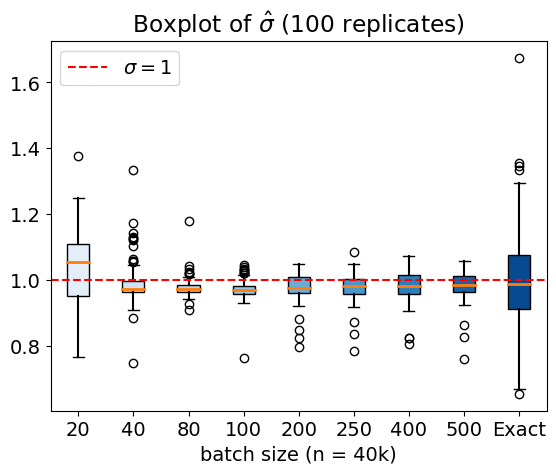

In [112]:
plot_time_boxplot(output_file, indic='variance')

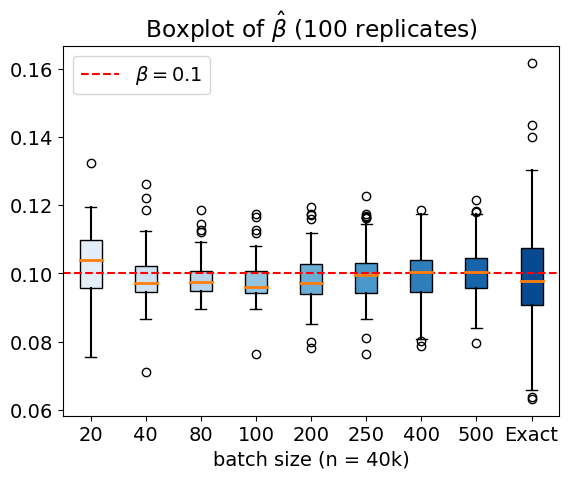

In [113]:
plot_time_boxplot(output_file, indic='range')

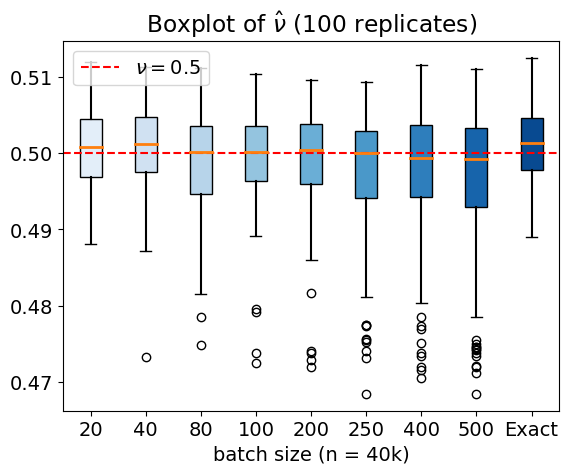

In [114]:
plot_time_boxplot(output_file, indic='smoothness')